# XGBoost with automatic cross-validated calibration

**Example using the xgb_auto function in the EasyMLR module**

The **xgb_auto** function in the EasyMLR module automatically finds the optimum set of cross-validated hyper-parameters and then outputs the fitted regression model and summary statistics using XGBoost with optuna.

The **xgb_auto** function standardizes the X input by default. 

This example shows how to check the cross-validation of the model with independent training and testing data subsets before fitting the final model with all of the data.

#### Example data set

This example uses the diabetes data described in the following tutorial by sklearn:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py


Before running this notebook, first install the EasyMLR module in your environment, if it is not already installed, using the following line in the next cell:

In [1]:
# !pip install git+https://github.com/gjpelletier/EasyMLR.git --upgrade

## Read X and y from the sklearn diabetes data set

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)

## Split X and y into cross-validation train and test subsets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model with the training data subset

In the next step, we will automatically find the best cross-validated hyper-parameters for XGBoost using optuna. Then we will fit the model using the training data with the best parameters. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...
XGBRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.750235 |
| RMSE        |      38.9573   |
| n_samples   |     353        |


Done
Time elapsed: 336.10 sec


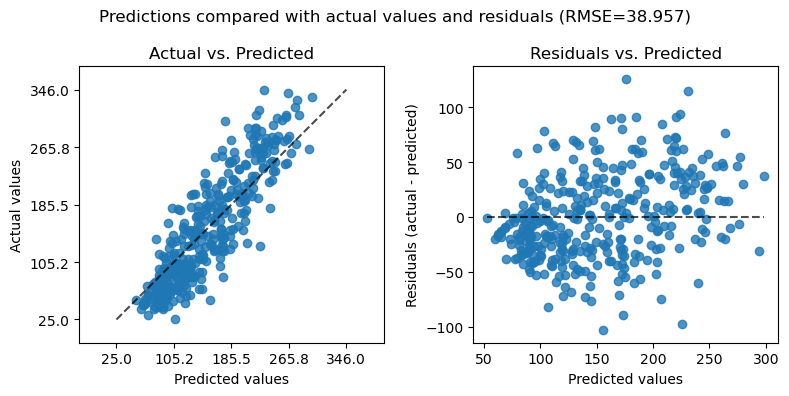

In [8]:
# Fit the model with the training data:
from EasyMLR import xgb_auto
train_model, train_output = xgb_auto(X_train, y_train)

## Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. 

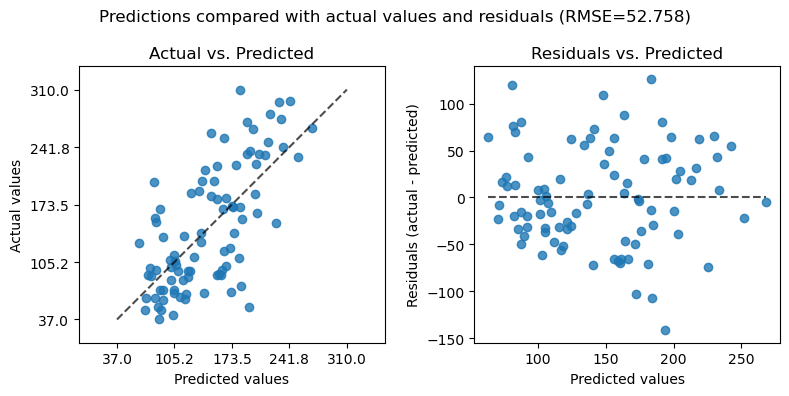

In [9]:
from EasyMLR import plot_predictions_from_test
fig = plot_predictions_from_test(train_model, X_test, y_test, scaler=train_output['scaler'])
fig.savefig("XGBRegressor_predictions_test.png", dpi=300)

## Final fit of the model using all of the X and y data

In the next step we will use the best parameters from the training model to fit the model using all of the X and y data.

Fitting XGBRegressor model, please wait ...


XGBRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.711859 |
| RMSE        |      41.3357   |
| n_samples   |     442        |


Done
Time elapsed: 1.14 sec


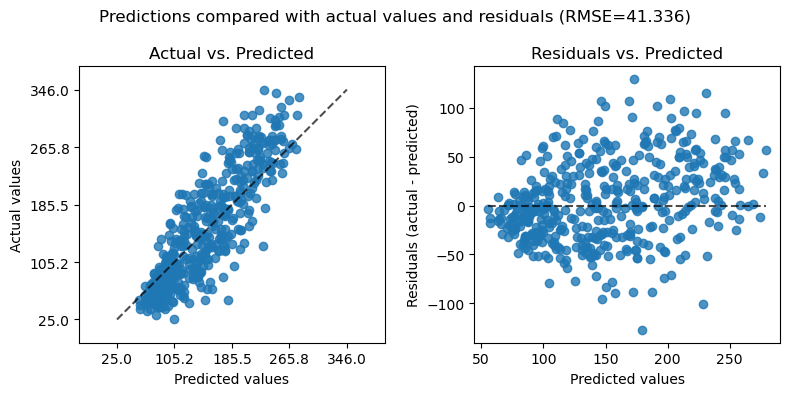

In [10]:
from EasyMLR import xgb
final_model, final_output = xgb(X, y, **train_output['best_params'])

## User instructions

In [11]:
help(xgb_auto)

Help on function xgb_auto in module EasyMLR:

xgb_auto(X, y, **kwargs)
    Autocalibration of XGBoost XGBRegressor hyper-parameters
    Beta version

    by
    Greg Pelletier
    gjpelletier@gmail.com
    04-June-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        verbose= 'on' (default) or 'off'
        standardize= 'on' (default) or 'off' where
            'on': standardize X using sklearn.preprocessing StandardScaler
            'off': do not standardize X (only used if X is already standardized)
        gpu= True (default) or False to autodetect if the computer has a gpu and use it
        'n_trials': 50,                     # number of optuna trials
        'random_state': 42,          